# Exercise 2: LQR & ILQR

> Welcome to the Advanced Robot Learning and Decision Making exercises!

In this exercise you will learn how to develop your own LQR and ILQR algorithms to stabilize the drone to a certain position. 



1. **Implement discrete-time, infinite-horizon LQR for hovering**
    
    Interface the Gymnasium Environment with the Controller, Linearize and Discretize the System, LQR control gains, and stabilize drone at target position.

2. **Implement ILQR for hovering**

    Linearize the System, Approximation of Costs, Policy Update, Implement backward pass, and stabilize drone at target position.

3. **Compare LQR and ILQR, and practical considerations.**


_____


##### Recap

The state $x$ of this robot is defined by the position of its center of mass and the body orientations, as well as their derivatives. The inputs $u$ that control the system are the vertical thrust $F_z$ and the desired roll, pitch, and yaw angles $(\phi_d, \theta_d, \psi_d)$ around each axis of a coordinate frame fixed to the quadrotor body ([attitude control interface](https://www.bitcraze.io/documentation/repository/crazyflie-firmware/master/functional-areas/sensor-to-control/controllers/)).

The continuous-time non-linear system dynamics in its general form are written down as

$$
\dot{x} = f(x) + g(x)\cdot u,
$$

where

$$
\mathbf{x} =
\begin{bmatrix}
x & \dot{x} & y & \dot{y} & z & \dot{z} & \phi & \theta & \psi & \dot{\phi} & \dot{\theta} & \dot{\psi}
\end{bmatrix}^T
$$

and

$$
u = [F_z, \phi_d, \theta_d, \psi_d]^T
$$

This system is underactuated with two degrees of underactuation—it has twelve states in total (or six degrees of freedom) and four independent actuation inputs. We implement this system in simulation using JAX ([crazyflow](https://github.com/utiasDSL/crazyflow)), as well as in a symbolic model using [CasADi](https://web.casadi.org/), as demonstrated in the previous exercise.

_____


Imports.

In [1]:
%load_ext autoreload
%autoreload 2

import time

import gymnasium
import matplotlib.pyplot as plt
import numpy as np
from crazyflow.constants import GRAVITY, MASS
from ilqr import ILQR
from lqr import LQR
from utils import obs_to_state

SEED = 42

Set up the environment.

In [2]:
env = gymnasium.make_vec(
    "DroneReachPos-v0",
    num_envs=1,
    freq=500,
    device="cpu",
    render_goal_marker=True,  # only for visualization
)

print("observation space: \n", env.observation_space)
print("action space: \n", env.action_space)
print("time step:", 1 / env.sim.freq)

observation space: 
 Dict('ang_vel': Box(-inf, inf, (1, 3), float32), 'difference_to_goal': Box(-inf, inf, (1, 3), float32), 'pos': Box(-inf, inf, (1, 3), float32), 'quat': Box(-inf, inf, (1, 4), float32), 'vel': Box(-inf, inf, (1, 3), float32))
action space: 
 Box([[ 0.11264675 -3.1415927  -3.1415927  -3.1415927 ]], [[0.5933658 3.1415927 3.1415927 3.1415927]], (1, 4), float32)
time step: 0.002


/home/vscode/venv/lib/python3.11/site-packages/gymnasium/envs/registration.py:982: UserWarning: WARN: The VectorEnv (CrazyflowEnvReachGoal(DroneReachPos-v0, num_envs=1)) is missing AutoresetMode metadata, metadata={}
  warn(


<div class="alert alert-warning">
    <h3>Recap: Action Space</h3>
    <p>The action space is a continuous space defined by a Box object with a shape of <b>(1, 4)</b>. The range for the first variable is <b>0.11264675 to 0.5933658</b>, while the other three variables range from <b>-π to π</b>. The actions are represented as <b>float32</b>.
         </p>
</div>

## 1 LQR

### 1.1 State Vector Representation

<div class="alert alert-info">
    <h3>Task 1: Reformat the Observation</h3>
    <p>
      Please implement the function <code>obs_to_state(obs)</code> in <code>exercise02/utils.py</code>. We need to reformat the dict observation returned by the simulation into a numpy array required by our controller:
    </p>
</div>

$$
\mathbf{x} =
\begin{bmatrix}
x & \dot{x} & y & \dot{y} & z & \dot{z} & \phi & \theta & \psi & \dot{\phi} & \dot{\theta} & \dot{\psi}
\end{bmatrix}^T
$$

   - $x$: Position in the x-direction.
   - $\dot{x}$: Velocity in the x-direction.
   - $y$: Position in the y-direction.
   - $\dot{y}$: Velocity in the y-direction.
   - $z$: Position in the z-direction.
   - $\dot{z}$: Velocity in the z-direction.
   - $\phi$: Roll angle.
   - $\theta$: Pitch angle.
   - $\psi$: Yaw angle.
   - $\dot{\phi}$: Roll angular velocity.
   - $\dot{\theta}$: Pitch angular velocity.
   - $\dot{\psi}$: Yaw angular velocity.

### 1.2 Linearization of system dynamics

As shown in the last exercise, we can easily obtain a CasADi symbolic model with very similar behavior to the simulation using <a href="https://github.com/utiasDSL/crazyflow/blob/d87bc1eaf100e7d8927731c630e52a7163108ecf/crazyflow/sim/symbolic.py#L291C5-L291C22"><code>symbolic_from_sim</code></a>. As we require the symbolic model for the controllers, this method is already being called for you in the <code>BaseController.get_symbolic</code> base class, and is available via the <code>model</code> property. 

<div class="alert alert-success">
    <h3>Task 2: Check Code</h3>
   <p>  Read the <code>__init__</code>, <code>setup_model</code> and <code>setup_linearization</code> methodes of the <a href="https://github.com/utiasDSL/crazyflow/blob/d87bc1eaf100e7d8927731c630e52a7163108ecf/crazyflow/sim/symbolic.py#L27"><code>SymbolicModel</code></a> class in <a href="https://github.com/utiasDSL/crazyflow/blob/d87bc1eaf100e7d8927731c630e52a7163108ecf/crazyflow/sim/symbolic.py"><code>crazyflow/sim/symbolic.py</code></a>. Understand how the symbolic representations of the drone’s dynamics, state, and cost functions are created. To understand this, you need some familarity with <a href="https://web.casadi.org/">CasADi</a>. You will need to interact with those definitions in the following tasks.
    </p>
</div>

To use the symbolic model for LQR, you first need to linearize the system. We denote the linear system with

$$
\dot{x} = A x + B u.
$$

<div class="alert alert-info">
    <h3>Task 3: Linearization</h3>
    <p>
      Go to <code>compute_lqr_gain</code> function in <code>exercise02/lqr.py</code>. Using the <code>symbolic model</code> to compute the linearized system matrices <code>A</code> and <code>B</code> at the equilibrium. 
    </p>
</div>

The discrete-time LQR controller requires discretized, linearized system dynamics $(A_k, B_k)$, whereas the function you implemented above still provides continuous, linearized system dynamics $(A, B)$. Next, we need to discretize the linearized dynamics.


A simple approximation between the two is given as follows:

$$
\begin{align*}
\delta \dot{x}(t) &= A \delta x(t) + B \delta u(t)  \\
\frac{\delta x_{k+1} - \delta x_k}{\delta t} &= A \delta x_k + B \delta u_k  \\
\delta x_{k+1} &= (I + A \delta t) \delta x_k + (B \delta t) \delta u_k,
\end{align*}
$$

as also stated in the previous exercise.

<div class="alert alert-info">
    <h3>Task 4: Discretization</h3>
    <p>
        Go to <code>exercise02/utils.py</code>, and finish the implementation of the function <code>discretize_linear_system</code>.
    </p>
</div>

### 1.3 Quadratic cost function

The infinite-horizon discrete-time quadratic cost function is given by:

$$
J(\bm{x_0}) = \sum_{k=0}^{\infty} \left( \bm{(x_k - x_{ref})}^T \bm{Q} \bm{(x_k - x_{ref})} + \bm{u_k}^T \bm{R} \bm{u_k} \right)
$$

<div class="alert alert-success">
    <h3>Task 5: Exam Preparation: Equilibrium and Cost Matrices</h3>
    <p>
        In the following cell, the equilibrium and weight matrices have been defined. You may start with the default values and later feel free to adjust the weight matrices.  
    </p>
</div>

In [3]:
# Operating point
x_op = np.array([0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0])  # State equilibrium
u_op = np.array([MASS * GRAVITY, 0.0, 0.0, 0.0], dtype=np.float32)  # Control equilibrium

# TODO later on in the exercise, experiment here with different values in the Q and R matrices.
q_diag = [
    5,
    3,  # penalize position and velocity
    5,
    3,
    5,
    3,
    0.1,
    0.1,
    2,  # penalize orientation
    1,
    1,
    1,  # penalize angular velocity
]
r_diag = [1, 1, 1, 1]
Q_lqr = np.diag(q_diag)  # State cost
R_lqr = np.diag(r_diag)  # Control cost

### 1.4 LQR controller gain

The solution to the LQR problem is obtained by solving the **Discrete Algebraic Riccati Equation (DARE):**

$$
\bm{S} = \bm{Q} + \bm{A}^T \bm{S} \bm{A} - (\bm{A}^T \bm{S} \bm{B})(\bm{R} + \bm{B}^T \bm{S} \bm{B})^{-1} (\bm{B}^T \bm{S} \bm{A})
$$

The optimal feedback control policy is given by:

$$
\bm{K} = \left( \bm{R} + \bm{B}^T \bm{S} \bm{B} \right)^{-1} \left( \bm{B}^T \bm{S} \bm{A} \right) \\
\bm{u^*} = -\bm{K} \bm{(x_k - x_{ref})}
$$

The implementation will follow three key steps:

1. **Obtain the system matrices**: Retrieve the $\bm{A}$ and $\bm{B}$ matrices from the discrete-time system dynamics;  
   *Hint*: you may use the method `discretize_linear_system()` to get the discretized system matrices  

2. **Solve for the Hessian matrix $\bm{S}$ of optimal cost**: Compute the solution to the Discrete Algebraic Riccati Equation (DARE) to obtain $\bm{S}$;  
   *Hint*: you may use the method `scipy.linalg.solve_discrete_are()` to solve DARE  

3. **Calculate the feedback gain $\bm{K}$**: Use the computed Hessian $\bm{S}$ to determine the LQR feedback gain $\bm{K}$;  
   *Hint*: you may use the method `numpy.linalg.inv()` to solve the inverse matrix 

<div class="alert alert-info">
    <h3>Task 6: LQR Gain</h3>
    <p>
        Go to <code>exercise02/lqr.py</code>, and finish the implementation of the function <code>compute_lqr_gain</code>.
    </p>
</div>

In [4]:
lqr_controller = LQR(env, x_op, u_op, Q_lqr, R_lqr)
gain_lqr = lqr_controller.gain

print("shape of gain:", gain_lqr.shape)

shape of gain: (4, 12)


### 1.5 Regulate the drone to the target state

<div class="alert alert-info">
    <h3>Task 7: Control Input</h3>
    <p>
        Please go to <code>exercise02/lqr.py</code> and implement the <code>step_control</code>. Then, run the following cell. Feel free to change the <code>goal</code>. Keep in mind that we test your implementation using different target goals on submission. If you are able to stabilize to the original goal provided by us, you should be fine.
    </p>
</div>

Note: you can use the `Tab`-key to switch between world and body camera in mujoco.

In [5]:
obs, info = env.reset(seed=SEED)
state = obs_to_state(obs)
# print(obs)
# Step through the environment
x_log = [state[0]]
y_log = [state[2]]
z_log = [state[4]]
control_input_log = []
fps = 60

# TODO: you can play around with the lqr_goal state
lqr_goal = np.array([0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0])  # set lqr_goal state

env.unwrapped.goal = env.unwrapped.goal.at[...].set(
    np.array([lqr_goal[0], lqr_goal[2], lqr_goal[4]])
)  # update lqr_goal in the environment for vizualization

for i in range(2500):
    control_input = lqr_controller.step_control(state, lqr_goal)

    control_input_log.append(control_input.flatten())
    obs, reward, terminated, truncated, info = env.step(control_input)

    state = obs_to_state(obs)
    # print('state:',state)
    x_log.append(state[0])
    y_log.append(state[2])
    z_log.append(state[4])

    if terminated or truncated:
        print("Episode ended at step:", i)
        break

    if (i * fps) % env.sim.freq < fps:
        env.render()
        env.unwrapped.sim.viewer.viewer.cam.lookat = env.unwrapped.goal[0]
        time.sleep(1 / fps)

env.sim.close()
env.close()

libGL error: glx: failed to create dri3 screen
libGL error: failed to load driver: nouveau
/home/vscode/venv/lib/python3.11/site-packages/glfw/__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


### 1.6 Plots

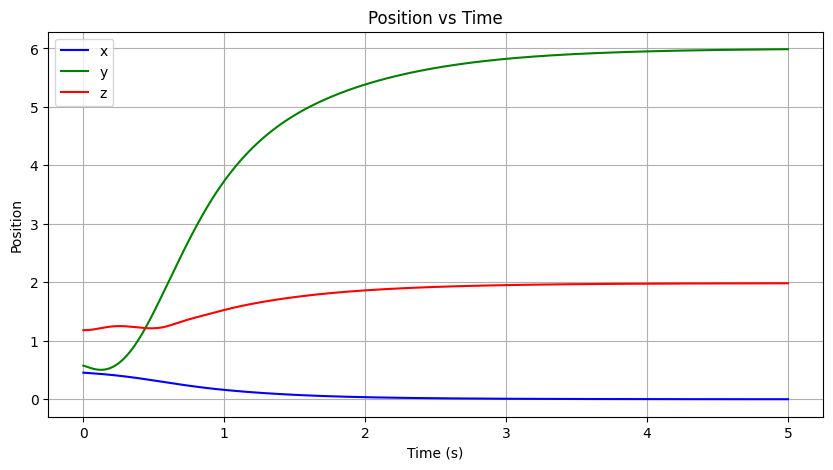

In [6]:
# Generate time array based on fixed step interval
dt = 1 / env.sim.freq
time_log = np.arange(len(x_log)) * dt

# Plot theta and control input vs. time
plt.figure(figsize=(10, 5))
plt.plot(time_log, x_log, label="x", color="blue")
plt.plot(time_log, y_log, label="y", color="green")
plt.plot(time_log, z_log, label="z", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Position")
plt.title("Position vs Time")
plt.legend()
plt.grid()
plt.show()


Check if the drone was stabilized at the desired position!

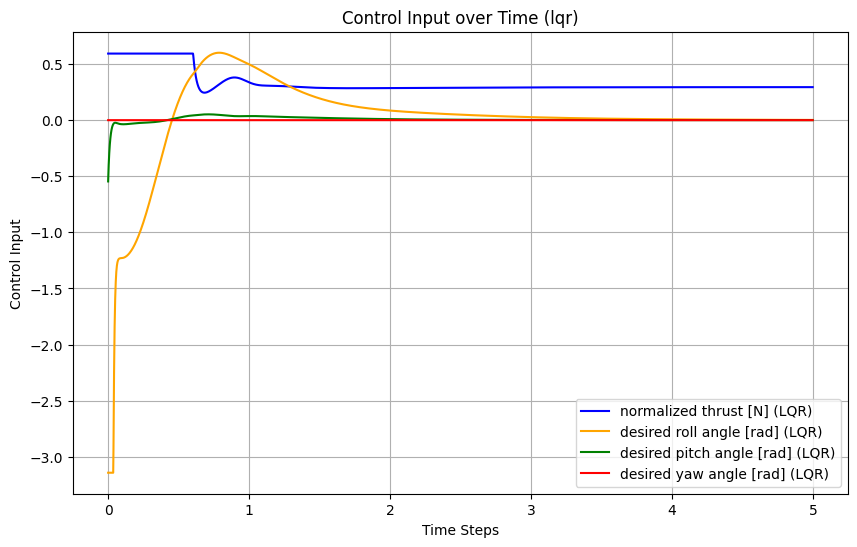

In [7]:
control_input_values = np.array(control_input_log)  # shape: (steps, 4)

time_log = np.arange(control_input_values.shape[0]) * dt

plt.figure(figsize=(10, 6))
plt.plot(time_log, control_input_values[:, 0], label="normalized thrust [N] (LQR)", color="blue")
plt.plot(
    time_log, control_input_values[:, 1], label="desired roll angle [rad] (LQR)", color="orange"
)
plt.plot(
    time_log, control_input_values[:, 2], label="desired pitch angle [rad] (LQR)", color="green"
)
plt.plot(time_log, control_input_values[:, 3], label="desired yaw angle [rad] (LQR)", color="red")

plt.xlabel("Time Steps")
plt.ylabel("Control Input")
plt.title("Control Input over Time (lqr)")
plt.legend()
plt.grid()
plt.show()

At the begining, the thrusts reached the maximum thrust of the motor.

<div class="alert alert-success">
    <h3>Task 8: Exam Preparation</h3>
    <p>
    How does the result change as we vary Qs and Rs?
    </p>
    <p>
    Submission is not required, but it’s crucial for the exam.
    </p>
</div>

<div class="alert alert-success">
    <h3>Task 9: Exam Preparation</h3>
    <p>
    How does the controller performance vary when the initial state changes and why?
    </p>
    <p>
    Submission is not required, but it’s crucial for the exam.
    </p>
</div>




<div class="alert alert-success">
    <h3>Task 10: Exam Preparation</h3>
    <p>
    How could you adapt the existing LQR controller implementation for tracking a moving target, instead of a static one? What has to change? What do you need to think about?
    </p>
</div>

## 2 ILQR

We now design an ILQC controller for the quadrotor reach-the-goal problem. We initialize the ILQC algorithm with the LQR control law obtained above and iteratively update the control law to minimize the prescribed cost function. 

### 2.1 Initialization of control policy

$$
\begin{aligned}
\mu_k(x_k) & = \bar{u}_k + \delta u_k^* \\
           & = \bar{u}_k - gain * \delta x_k \\
           & = \bar{u}_k - gain * (x_k - \bar{x}_k) \\
           & = \underbrace{\bar{u}_k + gain * \bar{x}_k}_{\text{feedforward } u_{k,\text{ff}}} 
            \underbrace{ - gain * x_k}_{\text{feedback}} \\
           & = u_{k,\text{ff}} + gain_{fb} * x_k.
\end{aligned}
$$

In [8]:
# Define desired state
ilqr_goal = np.array([0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0])  # goal state

nx = 12  # dimension of state vector
nu = 4  # dimension of input vector

input_ff = u_op + gain_lqr.dot(ilqr_goal)
gains_fb = -gain_lqr

input_ff = np.tile(input_ff.reshape(nu, 1), (1, 2500))
gains_fb = np.tile(gains_fb.reshape(1, nu, nx), (2500, 1, 1))

print("Shape of input_ff:", input_ff.shape)
print("Shape of gains_fb:", gains_fb.shape)

Shape of input_ff: (4, 2500)
Shape of gains_fb: (2500, 4, 12)



Recall that, in each ILQC iteration, we first perform a forward pass and roll out the states and inputs based on the control law from the previous iteration. We denote the sequence of rollout states as $ \{\bar{x}_k\}_{k=0}^N $ and the sequence of inputs as $ \{\bar{u}_k\}_{k=0}^{N-1} $, where $ N $ is the number of simulation time steps. In the questions below, we will derive the key elements of the backward pass for updating the control law in each iteration.

### 2.2 Backward Pass

Again, you need to linearize and discretize the system about an operating point $(\bar{x}_k, \bar{u}_k)$. The goal is to write a function that outputs the matrices of the linearized system for a given operating point $(\bar{x}_k, \bar{u}_k)$:

$$ A_k, B_k = \text{drone\_linear}(\bar{x}_k, \bar{u}_k, \delta t, \bar{v})$$

<div class="alert alert-info">
    <h3>Task 11: Linearized  and Discretized System Dynamics</h3>
    <p>
        Linearize and discretize the system dynamic on an operating point. Finish the implementation of the function <code> dynamic_lin_disc</code> in <code> exercise02/ilqr.py</code> :
    </p>
</div>

Time-discretize the cost function and express the cost function in the following form:

$$
J(x_0) = g_N (x_N) + \delta t \sum_{k=0}^{N-1} g_k(x_k, u_k), \tag{5}
$$

where $g_N(x_N)$ is the terminal cost and $g_k(x_k, u_k)$ is the stage cost. Derive second-order approximations of the terminal cost and the stage cost about $(\bar{x}_k, \bar{u}_k)$. The approximated costs should take the following forms:

$$
g_N(x_N) \approx \bar{g}_N + q_N^\top \delta x_N + \frac{1}{2} \delta x_N^\top Q_N \delta x_N, \tag{6}
$$

$$
g_k(x_k, u_k) \approx \bar{g}_k + q_k^\top \delta x_k + r_k^\top \delta u_k + \frac{1}{2} \delta x_k^\top Q_k \delta x_k + \frac{1}{2} \delta u_k^\top R_k \delta u_k + \delta u_k^\top P_k \delta x_k. \tag{7}
$$

Write functions that compute the terminal and the stage costs in Eqns. (6) and (7):

$$
\bar{g}_N, q_N, Q_N = \text{terminal\_cost\_quad}(Q_t, x_{\text{goal}}, \bar{x}_N)
$$

$$
\bar{g}_k, q_k, Q_k, r_k, R_k, P_k = \text{stage\_cost\_quad}(Q_s, R_s, x_{\text{goal}}, \delta t, \bar{x}_k, \bar{u}_k)
$$

<div class="alert alert-info">
    <h3>Task 12: Cost Approximation</h3>
    <p>
        Finish the implementation of the functions <code> terminal_cost_quad</code> and <code> stage_cost_quad</code> in <code> exercise02/ilqr.py</code>. (The suffix *_quat.py is for 'quadratic'.)
    </p>
</div>

The Bellman Equation (BE) for the value function at time step $ k $ can be written as:

$$
J^*(x_k) = \min_u \left( g_k(x_k, u_k) + J^*(x_{k+1}) \right). \tag{8}
$$

Assuming the following approximation of the value function $ J^*(x_{k+1}) $:

$$
J^*(x_{k+1}) \approx \bar{s}_{k+1} + \delta x_{k+1}^\top s_{k+1} + \frac{1}{2} \delta x_{k+1}^\top S_{k+1} \delta x_{k+1}, \tag{9}
$$

and given the approximate stage cost $ g_k(x_k, u_k) $ in Eqn. (7), derive an expression for the optimal $ \delta u_k^* $ at each time step. Express the updated control law $ u_k = \bar{u}_k + \delta u_k^* $ in the following form:

$$
u_k = \theta_{k,ff} + \theta_{k,fb} x_k,
$$

where $ \theta_{k,ff} \in \mathbb{R}^m $ and $ \theta_{k,fb} \in \mathbb{R}^{m \times n} $.

<div class="alert alert-success">
    <h3>Task 13: Exam Preparation: Derivation</h3>
    <p>
    Derive an expression for the optimal incremental policy. 
    </p>
    <p>
    Submission is not required, but it’s crucial for the next code task.
    </p>
</div>

<div class="alert alert-success">
    <h3>Task 14: Exam Preparation</h3>
    <p>
    Consider the following equations for updating <code>\bar{s}_k, s_k, S_k</code>. But how should we initialize them? 
    </p>
    <p>
    Submission is not required, but it’s crucial for code task and exam.
    </p>
</div>

The equations for updating $ \bar{s}_k $, $ s_k $, $ S_k $ from $ \bar{s}_{k+1} $, $ s_{k+1} $, $ S_{k+1} $ at each time step are:

$$
\bar{s}_k = \bar{g}_k + \bar{s}_{k+1} + \frac{1}{2} \delta u_{k,ff}^{*^\top} H_k \delta u_{k,ff}^* + \delta u_{k,ff}^{*^\top} l_k,
$$

$$
s_k = q_k + A_k^\top s_{k+1} + K_k^\top H_k \delta u_{k,ff}^* + K_k^\top l_k + G_k^\top \delta u_{k,ff}^*,
$$

$$
S_k = Q_k + A_k^\top S_{k+1} A_k + K_k^\top H_k K_k + K_k^\top G_k + G_k^\top K_k.
$$

<div class="alert alert-info">
    <h3>Task 15: Policy Update</h3>
    <p>
        Finish the implementation of the function <code> update_policy</code> in <code> exercise02/ilqr.py</code>, to update the control law and coefficients of the approximation of the value function at time step k.
    </p>
</div>


### 2.3 Iteratively update policy

Design cost weight matrices. Feel free to adjust them.

In [9]:
q_diag = [5, 3, 5, 3, 5, 3, 0.1, 0.1, 2, 1, 1, 1]
r_diag = [1, 1, 1, 1]
Q_ilqr = np.diag(q_diag)  # State cost weight
R_ilqr = np.diag(r_diag)  # Input cost weight

<div class="alert alert-info">
    <h3>Task 16: Complete ILQR</h3>
    <p>
        You have already implemented the key components of the backward pass of ILQR algorithm. Please go to <code> learn()</code> in <code>exercise02/ilqr.py</code> and complete the implementation of the ILQR algorithm.
    </p>
</div>

Once you finish the Task, please run the next cell. It will take some time. :)

In [10]:
ilqr_controller = ILQR(env, Q_ilqr, R_ilqr, ilqr_goal, input_ff, gains_fb)

ilqr_controller.learn()

Iteration: 0, Cost: [[44937.80490674]]
--------------------------
Iteration: 1, Cost: [[47091.12826922]]
--------------------------
Cost increased by [[2153.32336248]]. Set feedforward term and controller gain to that from the previous iteration. Increased lambda to 10.
Current policy is from iteration 0.
Iteration: 2, Cost: [[44937.80490674]]
--------------------------
Iteration: 3, Cost: [[45472.88873267]]
--------------------------
Cost increased by [[535.08382593]]. Set feedforward term and controller gain to that from the previous iteration. Increased lambda to 100.
Current policy is from iteration 2.


KeyboardInterrupt: 

### 2.4 Simulation

In [ ]:
obs, _ = env.reset(seed=SEED)
state = obs_to_state(obs)

env.unwrapped.goal = env.unwrapped.goal.at[...].set(np.array([ilqr_goal[0], ilqr_goal[2], ilqr_goal[4]])) # update goal in the environment for vizualization

x_log_ilqr = [state[0]]
y_log_ilqr = [state[2]]
z_log_ilqr = [state[4]]
control_input_log_ilqr = []

# Simulation loop
for i in range(2500):  # Simulate for 2500 steps
    # envs.render()

    # Compute control action (force) using the iLQR gain
    control_input = ilqr_controller.step_control(
        state, i
    )  # gains_fb[:, i].dot(state) + input_ff[i]

    # Clip the control input to the specified range
    control_input = np.clip(control_input, env.action_space.low, env.action_space.high)

    # Convert to np.ndarray
    action = control_input.reshape(1, 4).astype(np.float32)  # (1, 4)

    # Take a step in the environment with the computed action
    obs, reward, terminated, truncated, _ = env.step(action)
    state = obs_to_state(obs)

    # Log data
    x_log_ilqr.append(state[0])
    y_log_ilqr.append(state[2])
    z_log_ilqr.append(state[4])
    control_input_log_ilqr.append(action.flatten())

    # Check if the episode is terminated
    if terminated or truncated:
        print("Episode ended at step:", i)
        break

    if (i * fps) % env.sim.freq < fps:
        env.render()
        env.unwrapped.sim.viewer.viewer.cam.lookat = env.unwrapped.goal[0]
        time.sleep(1 / fps)
# Close the environment
env.sim.close()
env.close()

### 2.5 Plots

<div class="alert alert-success">
    <h3>Task 17: Exam Preparation</h3>
    <p>
    Try different initial conditions and plot the state and input. Comment on the difference between the LQR controller and the ILQR controller.
    </p>
    <p>
    E.g. [0,0,8,0,8,0,0,0,0,0,0,0]
    </p>
    <p>
    Submission is not required, but it’s crucial for the exam.
    </p>
</div>

<div class="alert alert-success">
    <h3>Task 18: Exam Preparation</h3>
    <p>
    How would the controllers' performence change when there is a mismatch between the model and the real system?
    </p>
    <p>
    Submission is not required, but it’s crucial for the exam.
    </p>
</div>

In [ ]:
# Generate time array based on fixed step interval
time_log = np.arange(len(x_log_ilqr)) * dt

# Plot theta and control input vs. time
plt.figure(figsize=(10, 5))
plt.plot(time_log, x_log_ilqr, label="x(iLQR)", color="blue")
plt.plot(time_log, y_log_ilqr, label="y(iLQR)", color="green")
plt.plot(time_log, z_log_ilqr, label="z(iLQR)", color="red")
plt.plot(time_log, x_log, label="x(LQR)", color="blue", linestyle="--")
plt.plot(time_log, y_log, label="y(LQR)", color="green", linestyle="--")
plt.plot(time_log, z_log, label="z(LQR)", color="red", linestyle="--")
plt.xlabel("Time (s)")
plt.ylabel("position")
plt.title("position vs Time")
plt.legend()
plt.grid()
plt.show()

In [ ]:
control_input_values_ilqr = np.array(control_input_log_ilqr)  # shape: (steps, 4)

time_log = np.arange(control_input_values.shape[0]) * dt

# Set up plot
plt.figure(figsize=(10, 6))

# Define labels, colors, and control inputs
control_labels = [
    ("normalized thrust [N]", "blue"),
    ("desired roll angle [rad]", "orange"),
    ("desired pitch angle [rad]", "green"),
    ("desired yaw angle [rad]", "red")
]

# Plot iLQR control inputs
for i, (label, color) in enumerate(control_labels):
    plt.plot(time_log, control_input_values_ilqr[:, i], label=f"{label} (iLQR)", color=color)

# Plot LQR control inputs with dashed lines
for i, (label, color) in enumerate(control_labels):
    plt.plot(time_log, control_input_values[:, i], label=f"{label} (LQR)", color=color, linestyle="--")

# Labeling the plot
plt.xlabel("Time Steps")
plt.ylabel("Control Input")
plt.title("Control Input over Time")
plt.legend()
plt.grid()
plt.show()

For further techniques on model and simulation based lqr techniques, please refer to [Reist et al, Simulation-Based LQR-Trees with Input and State Constraints](https://groups.csail.mit.edu/robotics-center/public_papers/Reist10.pdf).